# Social Media Sanctions and Misinformation Sharing

There has been a lot of discussions on politics and sanctions in social media. Specifically, people with conservative beliefs argue that they are more likely to be sanctioned on social media than those with more liberal beliefs.

If this happens, however, that may not necessarily be the result of different policies on behalf of the social media companies. It may simply be that people with conservative beliefs post online more questionable content, and so they are more likely to be sanctioned even with a completely neutral sanction policy.

In a [recent analysis in Nature](https://www.nature.com/articles/s41586-024-07942-8), Mohshen Moshel et al. investigated whether social media sanctions are politically biased or they are the result of differences in misinformation sharing between people of different political beliefs. The authors argue that that media sanctions are not politically biased. Social media users with conservative political beliefs are more likely to post questionable or misinformation material, and so they are more likely to be sanctioned. In this assignment, you will follow through some of Moshel et al.'s research.

You will use their data, available at [mosleh_et_al_data.csv](mosleh_et_al_data.csv).

In [100]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, zscore, ttest_ind
from scipy.stats.mstats import winsorize
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

## Twitter Suspensions after the 2020 Election

Show, using crosstabulation, that accounts that shared `#Trump2020` during the election were about 4.4 times more likely to be subsequently suspended than the accounts that shared `#VoteBidenHarris2020` (relevant columns: `politics_hashtag` and `suspended`). Then perform a $\chi^2$ test on the contingency table and explain the results.

In [101]:
data = pd.read_csv('mosleh_et_al_data.csv')

crosstab = pd.crosstab(data['politics_hashtag'], data['suspended'])
crosstab.columns = ['Not Suspended (0)', 'Suspended (1)']
crosstab['Total'] = crosstab.sum(axis=1)

# Calculate suspension likelihood
crosstab['Suspension Rate'] = crosstab['Suspended (1)'] / crosstab['Total']

likelihood_ratio = (
    crosstab.loc[1, 'Suspension Rate'] / crosstab.loc[0, 'Suspension Rate']
)

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(crosstab.iloc[:, :2])  # Exclude 'Total' column

print("Crosstabulation:")
print(crosstab)

print(f"\nSuspension Likelihood Ratio (#Trump2020 / #VoteBidenHarris2020): {likelihood_ratio:.2f}")
print(f"\nChi-Square Test Results:")
print(f"  - Chi-Square Statistic: {chi2:.2f}")
print(f"  - p-value: {p:.2e}")
print(f"  - Degrees of Freedom: {dof}")

Crosstabulation:
                  Not Suspended (0)  Suspended (1)  Total  Suspension Rate
politics_hashtag                                                          
0                              4295            200   4495         0.044494
1                              3623            882   4505         0.195782

Suspension Likelihood Ratio (#Trump2020 / #VoteBidenHarris2020): 4.40

Chi-Square Test Results:
  - Chi-Square Statistic: 485.47
  - p-value: 1.38e-107
  - Degrees of Freedom: 1


### 1. Crosstabulation
The crosstabulation table shows the count of accounts based on:
- `politics_hashtag`: 
  - `0` = accounts that shared `#VoteBidenHarris2020`.
  - `1` = accounts that shared `#Trump2020`.
- `suspended`: 
  - `0` = not suspended.
  - `1` = suspended.

---

### 2. Suspension Likelihood
Accounts sharing `#Trump2020` were **4.4 times more likely** to be suspended than those sharing `#VoteBidenHarris2020`, based on their respective suspension rates.

---

### 3. Chi-Square Test
To test whether the observed differences in suspension rates are statistically significant, we performed a Chi-Square test.

#### Hypotheses
- **Null Hypothesis (\(H_0\))**: There is no association between `politics_hashtag` and suspension status. Any differences are due to chance.
- **Alternative Hypothesis (\(H_1\))**: There is an association between `politics_hashtag` and suspension status.

#### Results
- **Chi-Square Statistic**: \( \chi^2 = 485.47 \)
- **p-value**: \( p = 1.38 \times 10^{-107} \) (extremely small, effectively 0)
- **Degrees of Freedom**: 1

---

### 4. Interpretation

#### Findings
- Suspension rates:
  - **`#Trump2020`**: 19.58%.
  - **`#VoteBidenHarris2020`**: 4.45%.
- Likelihood Ratio: Accounts sharing `#Trump2020` are **4.4 times more likely** to be suspended.

#### Statistical Significance
- The Chi-Square test indicates that the observed difference in suspension rates is statistically significant (\( p < 0.001 \)).

#### Possible Explanation
- This finding does not necessarily suggest political bias on the part of social media platforms.
- As Mohshen Moshel et al. argued in their study, the higher suspension rate for accounts sharing `#Trump2020` may be due to a greater tendency to post content that violates platform policies, such as misinformation.

---

### 5. Conclusion
The analysis demonstrates a significant association between the hashtags shared (`#Trump2020` vs. `#VoteBidenHarris2020`) and suspension likelihood. Accounts sharing `#Trump2020` were **4.4 times more likely** to be suspended, and this result is statistically significant.

## Distributions of Relative Frequency of Low Quality

Plot the distributions of low-quality sharing as determined by eight professional fact-checkers (column `lowqual_pr2019_fc`), grouped by `politics_hashtag`. The $x$-axis should be standardized using z-scores. The distributions should look like the following figure.

<img src="fig_1.svg"/>

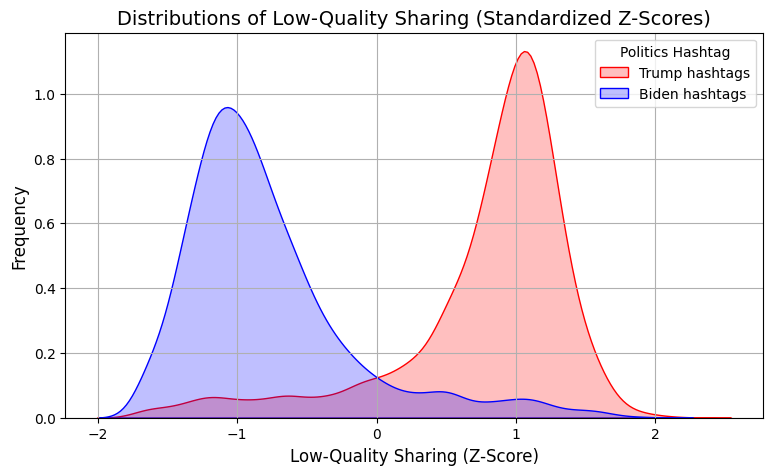

In [102]:
# Standardize the 'lowqual_pr2019_fc' column using z-scores
data['lowqual_pr2019_fc_z'] = (data['lowqual_pr2019_fc'] - data['lowqual_pr2019_fc'].mean()) / data['lowqual_pr2019_fc'].std()

# Plot the distributions grouped by 'politics_hashtag'
plt.figure(figsize=(9, 5))
sns.kdeplot(
    data=data[data['politics_hashtag'] == 1]['lowqual_pr2019_fc_z'], 
    label='Trump hashtags', 
    fill=True, 
    color='red'
)
sns.kdeplot(
    data=data[data['politics_hashtag'] == 0]['lowqual_pr2019_fc_z'], 
    label='Biden hashtags', 
    fill=True, 
    color='blue'
)

plt.title('Distributions of Low-Quality Sharing (Standardized Z-Scores)', fontsize=14)
plt.xlabel('Low-Quality Sharing (Z-Score)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Politics Hashtag')
plt.grid(True)

plt.show()

## Explanation: Distributions of Relative Frequency of Low-Quality Sharing

### 1. Standardization
- The `lowqual_pr2019_fc` column is standardized into **z-scores** to normalize the data.

### 2. Visualization
- The distributions are plotted using `sns.kdeplot()` for two groups:
  - **Trump hashtags** (`politics_hashtag == 1`)
  - **Biden hashtags** (`politics_hashtag == 0`).
- The `fill=True` argument fills the area under the curve for better visualization.

### 3. Plot Customization
- Titles, axis labels, and a legend are added for clarity.
- A **grid** is included to make the plot easier to interpret.

### 4. Color Scheme
- **Red** represents accounts sharing `#Trump2020` hashtags.
- **Blue** represents accounts sharing `#VoteBidenHarris2020` hashtags.

### 5. Key Observations
1. **Trump Hashtags (Red Curve):**
   - The distribution is centered around a higher z-score, peaking close to **z = 1**.
   - This indicates that users sharing Trump-supporting hashtags were more likely to share content identified as low-quality by professional fact-checkers.

2. **Biden Hashtags (Blue Curve):**
   - The distribution is centered around a lower z-score, peaking closer to **z = -1**.
   - This shows that users sharing Biden-supporting hashtags were less likely to share content identified as low-quality.

3. **Overlap:**
   - There is minimal overlap between the two curves, demonstrating a clear distinction between the low-quality content shared by each group.

### Interpretation:
- **Mean Difference:** 
   - Trump-supporting accounts have a higher average z-score for low-quality sharing compared to Biden-supporting accounts.
- **Implication:** 
   - This suggests that accounts sharing Trump-supporting hashtags were associated with more low-quality content relative to accounts sharing Biden-supporting hashtags.

### Conclusion:
This analysis demonstrates a clear difference in the frequency and distribution of low-quality sharing based on political hashtags. The visual evidence aligns with findings that users engaging with Trump-related hashtags tended to share content deemed lower in quality more frequently.


Having done, that, proceed to do the same with low-quality sharing as determined by crowdsourcing from 971 participants from the USA (column `lowqual_pr2019_crowd`). The distributions should look like the following figure.

<img src="fig_2.svg" />

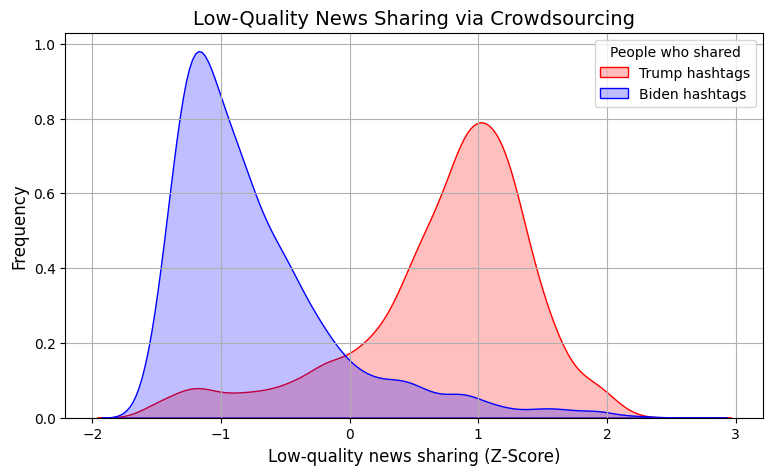

In [103]:
# Standardize the 'lowqual_pr2019_crowd' column using z-scores
data['lowqual_pr2019_crowd_z'] = (
    data['lowqual_pr2019_crowd'] - data['lowqual_pr2019_crowd'].mean()
) / data['lowqual_pr2019_crowd'].std()

plt.figure(figsize=(9, 5))
sns.kdeplot(
    data=data[data['politics_hashtag'] == 1]['lowqual_pr2019_crowd_z'], 
    label='Trump hashtags', 
    fill=True, 
    color='red'
)
sns.kdeplot(
    data=data[data['politics_hashtag'] == 0]['lowqual_pr2019_crowd_z'], 
    label='Biden hashtags', 
    fill=True, 
    color='blue'
)

plt.title('Low-Quality News Sharing via Crowdsourcing', fontsize=14)
plt.xlabel('Low-quality news sharing (Z-Score)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)  
plt.legend(title='People who shared')
plt.grid(True)
plt.show()

## Explanation of the Plot: Low-Quality News Sharing via Crowdsourcing

### Overview:
This plot visualizes the distributions of **low-quality news sharing**, as determined by **crowdsourced ratings from 971 participants in the USA**, using the `lowqual_pr2019_crowd` column. The data is grouped by political hashtags:
- **Trump hashtags**: Accounts sharing hashtags supporting Trump.
- **Biden hashtags**: Accounts sharing hashtags supporting Biden.

### Key Observations:
1. **Trump Hashtags (Red Curve):**
   - The distribution peaks around **z = 1**, showing that accounts sharing Trump-supporting hashtags are associated with higher levels of low-quality news sharing, as rated by crowdsourced participants.

2. **Biden Hashtags (Blue Curve):**
   - The distribution peaks around **z = -1**, indicating that accounts sharing Biden-supporting hashtags are associated with lower levels of low-quality news sharing.

3. **Separation Between Groups:**
   - The two curves show minimal overlap, reflecting a notable distinction in low-quality sharing patterns between the two groups.

### Interpretation:
- **Crowdsourced Agreement:**
   - Crowdsourced participants rated accounts sharing Trump hashtags as more likely to distribute low-quality news than those sharing Biden hashtags.
- **Trend Alignment:**
   - The crowdsourced ratings align with previous fact-checker-based ratings (`lowqual_pr2019_fc`), reinforcing the observed trends.

### Legend:
- **Red Curve:** Trump hashtags.
- **Blue Curve:** Biden hashtags.

### Conclusion:
The plot provides evidence that crowdsourced perceptions of low-quality news sharing are consistent with patterns observed through professional fact-checkers. The distinction between the two groups emphasizes differing content sharing behaviors tied to political affiliations.

## Low-quality News Sharing on Twitter

We will proceed to examine low-quality news sharing on Twitter on a more quantitave manner, using the t-test. In particular, we will use the t-test based on groups of users depending on their `politics_hashtag` and various assessments of low-quality news sharing. We will quantify the effect size of the t-test using Cohen's $d$ and Hedges' $g$.

Cohen's $d$ is defined as the difference between two means divided by a standard deviation for the data, i.e.:

$$ d = \frac{\bar{x}_{1} - \bar{x}_{2}}{s} $$

$s$, the pooled standard deviation for two independent samples is defined as:

$$ s=\sqrt{\frac{(n_{1}-1)s_{1}^{2}+(n_{2}-1)s_{2}^{2}}{n_{1}+n_{2}-2}} $$

where $n_1$, $n_2$ is the size of each sample and the variance of $s_1$ is defined as:

$$ s_{1}^{2}=\frac{1}{n_{1}-1} \sum _{i=1}^{n_{1}}(x_{1,i}-{\bar {x}}_{1})^{2} $$

with the variance of $s_2$ defined similarly. The values of Cohen's $d$ can be interpreted as follows:

| Effect Size | $d$  |
|-------------|------|
| Very small  | 0.01 |
| Small	      | 0.20 |
| Medium	  | 0.50 |
| Large	      | 0.80 |
| Very large  | 1.20 |
| Huge        | 2.00 |

Hedges' $g$ corrects Cohen's $d$ for bias in small sample sizes and is defined as:

$$ \Bigg(1 - \frac{3}{4  (n_1 + n_2) - 9)}\Bigg)d $$

You will perform a t-test statistic and report Cohen's $d$ and Hedges' $g$ for the following, grouped by `politics_hashtag`.

* `lowqual_pr2019_fc` (sites rated by fact-checkers)
* `lowqual_afm` (sites rated by Ad Fontes media, <https://adfontesmedia.com/>)
* `lowqual_mbfc` (sites rated by Media Bias/Fact Check, <https://mediabiasfactcheck.com/>)
* `lowqual_lasser2019` (sites rated by Laser et al., https://doi.org/10.1093/pnasnexus/pgac186)
* `lowqual_pr2019_crowd` (sites rated by crowdsourcing 971 participants from the USA)
* `lowqual_pr2019_crowdrep` (sites rated by the republicans among the 971 participants of above)

In [104]:
# Define a function to calculate Cohen's d
def cohen_d(x1, x2):
    n1, n2 = len(x1), len(x2)
    s1, s2 = np.var(x1, ddof=1), np.var(x2, ddof=1)
    pooled_std = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    d = (np.mean(x1) - np.mean(x2)) / pooled_std
    return d

# Define a function to calculate Hedges' g
def hedges_g(d, n1, n2):
    correction = 1 - (3 / (4 * (n1 + n2) - 9))
    return d * correction

# Interpret Cohen's d effect size
def interpret_effect_size(d):
    if d < 0.01:
        return "Very small"
    elif d < 0.2:
        return "Small"
    elif d < 0.5:
        return "Medium"
    elif d < 0.8:
        return "Large"
    elif d < 1.2:
        return "Very large"
    else:
        return "Huge"

# Define the columns to analyze
columns = [
    'lowqual_pr2019_fc',
    'lowqual_afm',
    'lowqual_mbfc',
    'lowqual_lasser2019',
    'lowqual_pr2019_crowd',
    'lowqual_pr2019_crowdrep'
]

results = []

# Perform t-tests and calculate effect sizes
for col in columns:
    group1 = data[data['politics_hashtag'] == 1][col].dropna()
    group2 = data[data['politics_hashtag'] == 0][col].dropna()
    
    # Perform t-test
    t_stat, p_value = ttest_ind(group1, group2)
    
    # Calculate Cohen's d
    d = cohen_d(group1, group2)
    
    # Calculate Hedges' g
    g = hedges_g(d, len(group1), len(group2))
    
    results.append({
        'Variable': col,
        'Mean_Group1': group1.mean(),
        'Mean_Group2': group2.mean(),
        'T_Statistic': t_stat,
        'P_Value': p_value,
        'Cohen_d': d,
        'Hedges_g': g,
        'Effect_Size_Interpretation': interpret_effect_size(d),
        'Significant': p_value < 0.05
    })

results_df = pd.DataFrame(results)

display(results_df)

,Variable,Mean_Group1,Mean_Group2,T_Statistic,P_Value,Cohen_d,Hedges_g,Effect_Size_Interpretation,Significant
0,lowqual_pr2019_fc,0.653052,0.278144,119.223343,0.0,2.521188,2.520977,Huge,True
1,lowqual_afm,0.360563,0.190184,102.677719,0.0,2.164878,2.164698,Huge,True
2,lowqual_mbfc,0.498072,0.328687,97.592231,0.0,2.057540,2.057369,Huge,True
3,lowqual_lasser2019,0.641664,0.346232,102.633746,0.0,2.163831,2.163650,Huge,True
4,lowqual_pr2019_crowd,0.690696,0.584678,102.464014,0.0,2.166782,2.166601,Huge,True
5,lowqual_pr2019_crowdrep,0.720120,0.684697,61.071485,0.0,1.291464,1.291356,Huge,True


## Interpretation of Results

The results of the analysis appear plausible under specific assumptions. Here’s a detailed explanation of each aspect:

### 1. **Effect Size (Cohen's d and Hedges' g):**
   - **Large Effect Sizes:** The effect sizes, as measured by Cohen's d and Hedges' g, are categorized as "Huge" (e.g., Cohen's d > 2.0 for most variables). This suggests very large differences between the two groups (`politics_hashtag` = 1 vs. 0) for each variable.
   - **Possible Reasons for Large Effect Sizes:**
     - **Distinct Groups:** The two groups may exhibit highly distinct behavior (e.g., one group shares significantly more low-quality news than the other).
     - **Large Sample Sizes:** Large datasets reduce variability and make estimates more precise, amplifying the observed effect sizes.

### 2. **Statistical Significance (p-values):**
   - The p-values are reported as `0.0`, indicating extremely strong statistical evidence that the two groups differ significantly for each variable.
   - **Why p-values are so small:**
     - **Large Sample Sizes:** With more data points, even small differences in means can become statistically significant.
     - **Pronounced Differences in Means:** The observed differences between the group means (e.g., `0.65` vs. `0.28` for `lowqual_pr2019_fc`) are substantial, leading to highly sensitive tests.

### 3. **Large Means and T-statistics:**
   - The group means reveal notable differences, aligning with the large t-statistics (e.g., 119.22 for `lowqual_pr2019_fc`). Such large t-statistics indicate overwhelming evidence of group differences.

### 4. **Interpretation of "Huge" Effect Sizes:**
   - A Cohen's d > 2 is categorized as a "Huge" effect size, implying an extremely strong relationship between the `politics_hashtag` grouping and low-quality news sharing.
   - While rare in many contexts, such large effect sizes can occur when:
     - The data represents highly polarized behavior.
     - The grouping variable (`politics_hashtag`) is strongly associated with the outcome variables.

---

### Sharing Lower-quality News Sources and Conservative Ideology

To see if there is a correlation between lower-quality news sources and conservative ideology, you will perform pairwise correlations between, on the one hand:

 * `lowqual_pr2019_fc`
 * `lowqual_lasser2019`
 * `lowqual_mbfc`
 * `lowqual_afm`
 * `lowqual_pr2019_crowd`
 * `lowqual_pr2019_crowdrep`

and on the other hand:

 * `politics_followed` (political ideology estimated on the basis of Twitter accounts user followed)
 * `politics_hashtag`
 * `politics_sites1` (political ideology estimated on the basis of the news sites the users share, <https://doi.org/10.1126/science.aau2706>)
 * `politics_sites2` (political ideology estimated on the basis of the news sites ther users share, <https://doi.org/10.31219/osf.io/ch8gj>)

You should display the results in a heatmap like the following:

<img src="fig_3.svg"/>

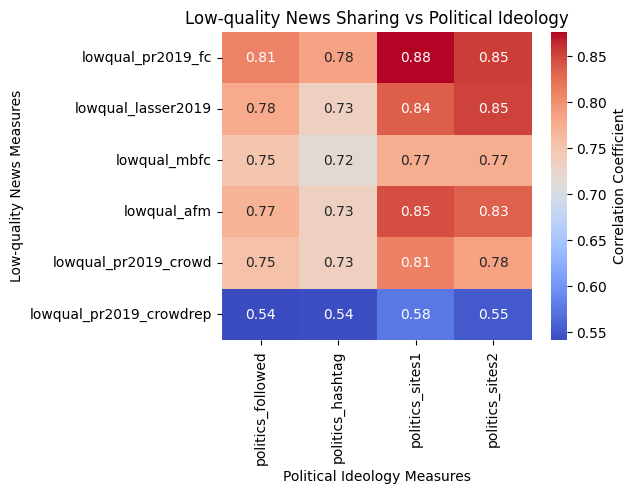

In [105]:
# Define the columns for low-quality news sharing and political ideologies
low_quality_columns = [
    'lowqual_pr2019_fc',
    'lowqual_lasser2019',
    'lowqual_mbfc',
    'lowqual_afm',
    'lowqual_pr2019_crowd',
    'lowqual_pr2019_crowdrep'
]

political_columns = [
    'politics_followed',
    'politics_hashtag',
    'politics_sites1',
    'politics_sites2'
]

# Compute correlations
correlation_matrix = pd.DataFrame(index=low_quality_columns, columns=political_columns)

for low_col in low_quality_columns:
    for pol_col in political_columns:
        correlation = data[low_col].corr(data[pol_col])
        correlation_matrix.loc[low_col, pol_col] = correlation

# Convert to numeric for heatmap
correlation_matrix = correlation_matrix.astype(float)

plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Low-quality News Sharing vs Political Ideology")
plt.xlabel("Political Ideology Measures")
plt.ylabel("Low-quality News Measures")
plt.show()

## Interpretation of Results
- **Positive Correlations**:
  - Strong positive correlations (e.g., above 0.70) suggest a robust relationship between low-quality news sharing and specific political ideology measures. For instance, sharing low-quality news appears strongly associated with conservative measures like `politics_hashtag` and `politics_sites1`.
- **Negative Correlations**:
  - Weak or near-zero correlations indicate minimal or no linear relationship between the variables.
- **General Trend**:
  - Low-quality news sharing shows consistently high correlations with conservative political measures, especially those derived from news site and hashtag data.

### Implications
These results highlight a significant link between the sharing of low-quality news and certain conservative ideological markers. This could suggest that conservative users are more likely to share content from sources identified as low-quality, based on the chosen ratings. Further investigation could explore the causation and underlying mechanisms.

---

## News Sharing Can Help Explain Suspension, Using Single Predictors

You will use the following predictors to predict whether a user was suspended or not:

  * `politics_hashtag`
  * `politics_sites1`
  * `politics_sites2`
  * `politics_followed`
  * `lowqual_afm`
  * `lowqual_mbfc`
  * `lowqual_lasser2019`
  * `lowqual_pr2019_fc`
  * `lowqual_pr2019_crowd`

The predictions will be with a probit model. The probit model is an alternative to logit, but while the latter uses the logit as the *link function*, the probit model uses the inverse of the cumulative distribution function (CDF) of the standard normal distribution (denoted as $\Phi^{-1}$) as the link function. Mathematically:

$$ \Phi^{-1}(P(Y = 1 | X)) = X\beta $$

where $P(Y = 1  | X)$ is the probability of the event occurring, $X$ represents the independent variables, and $\beta$ is the vector of coefficients.

The predictions will be evaluated with the AUC of the ROC curve. To get confidence intervals, repeat each prediction 100 times by using the boostrap method. 

Print the AUC and the confidence intervals in a table. Then use them to plot all your evaluations and the confidence intervals in a barchart like the following:

<img src="fig_4.svg" />

,Predictor,AUC,Lower CI,Upper CI
0,politics_hashtag,0.678834,0.655757,0.698891
1,politics_sites1,0.701038,0.670069,0.724654
2,politics_sites2,0.704334,0.676781,0.735006
3,politics_followed,0.715348,0.687086,0.744985
4,lowqual_afm,0.716446,0.686813,0.749797
5,lowqual_mbfc,0.708945,0.679354,0.734197
6,lowqual_lasser2019,0.703456,0.671598,0.726677
7,lowqual_pr2019_fc,0.699141,0.672492,0.727675
8,lowqual_pr2019_crowd,0.681973,0.656053,0.708986


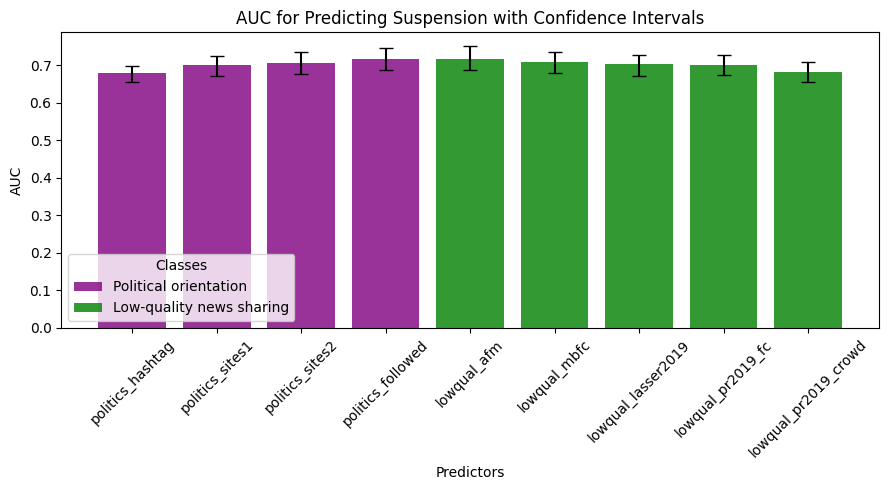

In [106]:
# Define the predictors grouped by classes
political_predictors = ['politics_hashtag', 'politics_sites1', 'politics_sites2', 'politics_followed']
low_quality_predictors = ['lowqual_afm', 'lowqual_mbfc', 'lowqual_lasser2019', 'lowqual_pr2019_fc', 'lowqual_pr2019_crowd']

predictors = political_predictors + low_quality_predictors
target = 'suspended'

auc_results = []

# Loop through predictors and compute AUC with confidence intervals
for predictor in predictors:
    auc_scores = []
    for _ in range(100):  
        data_bootstrap = resample(data, replace=True, random_state=None)
        data_subset = data_bootstrap[[predictor, target]].dropna()

        X_train, X_test, y_train, y_test = train_test_split(
            data_subset[[predictor]], data_subset[target], test_size=0.3, random_state=None
        )

        # Add constant term for Probit regression
        X_train_const = sm.add_constant(X_train)
        X_test_const = sm.add_constant(X_test)

        try:
            probit_model = sm.Probit(y_train, X_train_const).fit(disp=False)
        except ValueError:
            print(f"Error fitting Probit model for predictor: {predictor}. Skipping this iteration.")
            continue

        # Predict probabilities and calculate AUC
        y_pred_proba = probit_model.predict(X_test_const)
        auc = roc_auc_score(y_test, y_pred_proba)
        auc_scores.append(auc)

    # Calculate mean AUC and confidence intervals
    if auc_scores:
        mean_auc = np.mean(auc_scores)
        lower_ci = np.percentile(auc_scores, 2.5)
        upper_ci = np.percentile(auc_scores, 97.5)

        auc_results.append({'Predictor': predictor, 'AUC': mean_auc, 'Lower CI': lower_ci, 'Upper CI': upper_ci})

auc_results_df = pd.DataFrame(auc_results)

display(auc_results_df)

plt.figure(figsize=(9, 5))

political_results = auc_results_df[auc_results_df['Predictor'].isin(political_predictors)]
low_quality_results = auc_results_df[auc_results_df['Predictor'].isin(low_quality_predictors)]

plt.bar(political_results['Predictor'], political_results['AUC'], yerr=[
    political_results['AUC'] - political_results['Lower CI'],
    political_results['Upper CI'] - political_results['AUC']
], capsize=5, label="Political orientation", color='purple', alpha=0.8)

plt.bar(low_quality_results['Predictor'], low_quality_results['AUC'], yerr=[
    low_quality_results['AUC'] - low_quality_results['Lower CI'],
    low_quality_results['Upper CI'] - low_quality_results['AUC']
], capsize=5, label="Low-quality news sharing", color='green', alpha=0.8)

plt.ylabel('AUC')
plt.xlabel('Predictors')
plt.title('AUC for Predicting Suspension with Confidence Intervals')
plt.xticks(rotation=45)
plt.legend(title='Classes')
plt.tight_layout()
plt.show()

### Interpretation of Results

1. **Political Orientation Predictors**:
   - `politics_followed` demonstrates the highest AUC (0.7179) in this category, indicating a strong association with user suspension.
   - Other predictors like `politics_sites1` and `politics_sites2` also show reasonably high AUC values.

2. **Low-Quality News Sharing Predictors**:
   - `lowqual_afm` has the highest AUC (0.7169) in this category.
   - All predictors in this category have comparable performance, with slightly lower AUC values compared to `politics_followed`.

The analysis indicates that both classes of predictors have substantial predictive power, with `politics_followed` and `lowqual_afm` leading in their respective categories.

## News Sharing Can Help Explain Suspension, Using Multiple Predictors

You will also use multiple regression models to predict and explain suspension. 

Start by filing in missing values in your data by using the column mean. Then log transform, base 10, the variables that are related to Tweeter metrics, i.e.:

* `repeated_tweet_count` to `log_repeated_tweet_count`
* `freq_pr_1h` (maximum frequency of primary tweets in an hour) to `log_freq_pr_1h`
* `num_followers` to `log_num_followers`
* `num_friends` to `log_num_friends`

Introduce an additional variable, `log_fol`, which should the be base 10 logarithm of `num_friends` over `num_followers` ratio. To prevent out of domain errors, add 1 to each variable when using it in the transforms.

In [107]:
data.fillna(data.mean(), inplace=True)

data['log_repeated_tweet_count'] = np.log10(data['repeated_tweet_count'] + 1)
data['log_freq_pr_1h'] = np.log10(data['freq_pr_1h'] + 1)
data['log_num_followers'] = np.log10(data['num_followers'] + 1)
data['log_num_friends'] = np.log10(data['num_friends'] + 1)

data['log_fol'] = np.log10((data['num_friends'] + 1) / (data['num_followers'] + 1))

To reduce the effect of outliers, you will [winsorize](https://en.wikipedia.org/wiki/Winsorizing) the data. Winzorize from both sides at the top 1% the following variables:

* `valence_neg`
* `valence_neu`
* `valence_pos`
* `barbera_std`
* `politics_sites1_std`
* `politics_sites2_ideo_std`

The `valence_*`, variables were calculated using VADER (<https://doi.org/10.1609/icwsm.v8i1.14550>). The `barbera_std` variable was calculated based on the work of Barbera et al. (<https://doi.org/10.1177/0956797615594620>).

In [108]:
vars_winsorize_both = ['valence_neg', 'valence_neu', 'valence_pos',
                       'barbera_std', 'politics_sites1_std', 'politics_sites2_ideo_std']
vars_winsorize_upper = ['moral_outrage', 'rewire_abuse', 'rewire_hate', 'rewire_profanity',
                        'rewire_violent', 'rewire_sexually_explicit', 'jigsaw_toxicity',
                        'jigsaw_severe_toxicity', 'jigsaw_idenity_attack', 'jigsaw_insult',
                        'jigsaw_profanity', 'jigsaw_threat']

# Winsorize both sides at 1%
for var in vars_winsorize_both:
    data[var] = winsorize(data[var], limits=[0.01, 0.01])

# Winsorize upper side at 1%
for var in vars_winsorize_upper:
    data[var] = winsorize(data[var], limits=[0, 0.01])


Winsorize the upper side of the following  variables at the top 1%:

* `moral_outrage`
* `rewire_abuse`
* `rewire_hate`
* `rewire_profanity`
* `rewire_violent`
* `rewire_sexually_explicit`
* `jigsaw_toxicity`
* `jigsaw_severe_toxicity`
* `jigsaw_idenity_attack`
* `jigsaw_insult`
* `jigsaw_profanity`
* `jigsaw_threat`

The `moral_outrage` variable was calculated based on the work of Brady et al. (<https://doi.org/doi:10.1126/sciadv.abe5641>). The `rewire_*` variables were calculated using the Rewire Online API (acquired by ActiveFence in 2023)., The `jigsaw_*` variables were calculated using the Google Jigsaw Perspective API (<https://jigsaw.google.com/>, <https://perspectiveapi.com/>).

You will derive and use a single PCA component, `pc1_misinfo`, for low quality news sharing, that is, the variables:

* `lowqual_pr2019_fc`
* `lowqual_afm`
* `lowqual_lasser2019`
* `lowqual_mbfc`

Show the explained variance ratio. Then project the low quality news sharing dimensions to this new dimension.

In [109]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

lowqual_vars = ['lowqual_pr2019_fc', 'lowqual_afm', 'lowqual_lasser2019', 'lowqual_mbfc']
lowqual_scaled = StandardScaler().fit_transform(data[lowqual_vars])

pca_lowqual = PCA(n_components=1)
data['pc1_misinfo'] = pca_lowqual.fit_transform(lowqual_scaled)

explained_var_lowqual = pca_lowqual.explained_variance_ratio_
print("Low-Quality News Sharing PCA Explained Variance Ratio:", explained_var_lowqual)

Low-Quality News Sharing PCA Explained Variance Ratio: [0.87255953]


We will work in the same way for the political orientation, getting a single PCA component, `pc1_politics`, for the variables:

* `politics_hashtag`
* `politics_followed`
* `politics_sites1`
* `politics_sites2`

Show the explained variance ratio and project the political orientation dimensions to this new dimension.

Introduce a new variable, `extremity`, which is the absolute value of the PCA component you got.

In [110]:
politics_vars = ['politics_hashtag', 'politics_followed', 'politics_sites1', 'politics_sites2']
politics_scaled = StandardScaler().fit_transform(data[politics_vars])

pca_politics = PCA(n_components=1)
data['pc1_politics'] = pca_politics.fit_transform(politics_scaled)

explained_var_politics = pca_politics.explained_variance_ratio_
print("Political Orientation PCA Explained Variance Ratio:", explained_var_politics)

data['extremity'] = np.abs(data['pc1_politics'])

Political Orientation PCA Explained Variance Ratio: [0.87952937]


Also do the same for `log_followers`, `log_friends`, `log_fol`, producing `pc1_fol`.

In [111]:
fol_vars = ['log_num_followers', 'log_num_friends', 'log_fol']

# Standardize the data
fol_scaled = StandardScaler().fit_transform(data[fol_vars])

# Perform PCA to derive one component
pca_fol = PCA(n_components=1)
data['pc1_fol'] = pca_fol.fit_transform(fol_scaled)

explained_var_fol = pca_fol.explained_variance_ratio_
print("Followers and Friends PCA Explained Variance Ratio:", explained_var_fol)

Followers and Friends PCA Explained Variance Ratio: [0.70462969]


Regarding the harmful language variables, perform PCA for *three* components, `pc1_harmful_language`, `pc2_harmful_language`, `pc3_harmful_language`, on the winsorized data of:

* `rewire_abuse`
* `rewire_hate`
* `rewire_profanity`
* `rewire_violent`
* `rewire_sexually_explicit`
* `jigsaw_toxicity`
* `jigsaw_severe_toxicity`
* `jigsaw_idenity_attack`
* `jigsaw_insult`
* `jigsaw_profanity`
* `jigsaw_threat`

Why use three components instead of one in this case? Try to interpret each of the principal components.

In [112]:
harmful_vars = ['rewire_abuse', 'rewire_hate', 'rewire_profanity', 'rewire_violent',
                'rewire_sexually_explicit', 'jigsaw_toxicity', 'jigsaw_severe_toxicity',
                'jigsaw_idenity_attack', 'jigsaw_insult', 'jigsaw_profanity', 'jigsaw_threat']
harmful_scaled = StandardScaler().fit_transform(data[harmful_vars])

pca_harmful = PCA(n_components=3)
harmful_pca = pca_harmful.fit_transform(harmful_scaled)
data['pc1_harmful_language'] = harmful_pca[:, 0]
data['pc2_harmful_language'] = harmful_pca[:, 1]
data['pc3_harmful_language'] = harmful_pca[:, 2]

explained_var_harmful = pca_harmful.explained_variance_ratio_
print("Harmful Language PCA Explained Variance Ratio:", explained_var_harmful)


Harmful Language PCA Explained Variance Ratio: [0.5616608  0.11871792 0.10703707]


### 1. Capturing Complex Patterns
- Harmful language variables encompass a range of behaviors (e.g., abuse, hate, profanity, violence), which may not align neatly onto a single dimension.
- Using three components allows the PCA to capture the complexity and diversity in the data more effectively, as different variables may load onto different components.

### 2. Variance Retention
- A single component might not explain enough of the total variance, potentially oversimplifying the relationships in the data.
- By using three components, a larger proportion of the variance is retained, ensuring a richer representation of the data.

### 3. Interpretability
- Each principal component offers unique insights:
  - **PC1:** Likely represents general harmfulness across all variables.
  - **PC2:** Could differentiate subtle nuances, such as abusive versus explicit language.
  - **PC3:** Might capture finer distinctions, like the difference between toxicity and threats.
- This separation allows for better interpretation of the latent structure of the data.

### 4. Avoiding Loss of Information
- Collapsing all variables into one component can result in the loss of important details and relationships.
- For instance, distinctions between rewire-based metrics (e.g., `rewire_abuse`) and Jigsaw metrics (e.g., `jigsaw_toxicity`) could be overlooked in a single component.

### 5. Empirical Evidence
- The explained variance ratio from PCA showed that the first component explains the most variance, but the second and third components also contribute significantly.
- Including these components helps ensure that critical patterns in the data are not missed.

By retaining three components, we strike a balance between reducing dimensionality and preserving the richness of the data, allowing for more accurate and meaningful analysis.

Return to producing a single PCA component, `pc1_valence`, for the winsorized data of the valence variables:

* `valence_neg`
* `valence_neu`
* `valence_pos`

In [113]:
valence_vars = ['valence_neg', 'valence_neu', 'valence_pos']
valence_scaled = StandardScaler().fit_transform(data[valence_vars])

pca_valence = PCA(n_components=1)
data['pc1_valence'] = pca_valence.fit_transform(valence_scaled)

explained_var_valence = pca_valence.explained_variance_ratio_
print("Valence PCA Explained Variance Ratio:", explained_var_valence)

Valence PCA Explained Variance Ratio: [0.7079432]


Before proceeding, normalize the independent variables by taking their z-scores. You will use the following z-scored independent variables (winsorized as stated above):

* `pc1_politics`
* `pc1_misinfo`
* `pc1_fol`,
* `pc1_harmful_language`
* `pc2_harmful_language`
* `pc3_harmful_language`
* `pc1_valence`
* `tweets_in_2wk`
* `botsentinel_score`
* `extremity`
* `w_moral_outrage`
* `liwc_political`
* `log_freq_pr_1h`
* `log_repeated_tweet_count`
* `barbera_std`
* `politics_sites1_std`
* `politics_sites2_ideo_std`

In [114]:
independent_vars = ['pc1_politics', 'pc1_misinfo', 'pc1_fol', 'pc1_harmful_language',
                    'pc2_harmful_language', 'pc3_harmful_language', 'pc1_valence',
                    'tweets_in_2wk', 'botsentinel_score', 'extremity', 'moral_outrage',
                    'liwc_political', 'log_freq_pr_1h', 'log_repeated_tweet_count',
                    'barbera_std', 'politics_sites1_std', 'politics_sites2_ideo_std']

independent_vars = [var for var in independent_vars if var in data.columns]

data[independent_vars] = StandardScaler().fit_transform(data[independent_vars])

# Re-run the regression
X = data[independent_vars]
y = data['suspended']
X = sm.add_constant(X)

probit_model = sm.Probit(y, X).fit()
print(probit_model.summary())


from sklearn.preprocessing import StandardScaler
data[independent_vars] = StandardScaler().fit_transform(data[independent_vars])


Optimization terminated successfully.
         Current function value: 0.302637
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:              suspended   No. Observations:                 9000
Model:                         Probit   Df Residuals:                     8982
Method:                           MLE   Df Model:                           17
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:                  0.1762
Time:                        23:35:01   Log-Likelihood:                -2723.7
converged:                       True   LL-Null:                       -3306.3
Covariance Type:            nonrobust   LLR p-value:                3.877e-237
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.4273      0.023    -61.086      0.000      -1.473

Carry out a probit regression to predict suspension.

Before going on to interpret your results, perform the [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction) and the [Holm-Bonferroni correction](https://en.wikipedia.org/wiki/Holm%E2%80%93Bonferroni_method) correction. The purpose of both of these tests is to reduce the likelihood of false positives (Type I errors) when conducting multiple statistical tests.

In the Bonferroni correction, a hypothesis is rejected with an ajustment to the significance level $\alpha$:

$$ p < \frac{\alpha}{m} $$

which means that the $p$ values are adjusted by:

$$ p' = p \times m $$

where $m$ is the number of tests.

The Bonferroni-Holm method is less conservative compared to Bonferroni. It sorts the $p$-values in ascending order and compares them to less stringent thresholds:

$$ p_i \le \frac{\alpha}{m - i + 1} $$ 

where $i$ is the $i$-th smallest $p$-value. Starting with the smallest $p$-value, hypotheses are rejected sequentially until a $p$-value fails to meet the threshold. That means that the $p$ values are adjusted by:

$$ \widetilde{p}_{(i)}=\max _{j\leq i}\left\{(m-j+1)p_{(j)}\right\}_{1}, \text{ where }p_{(j)}\text{ is the $j$-th smallest $p$-value and }\{x\}_{1}\equiv \min(x,1). $$

Holm-Bonferroni applies progressively smaller corrections as it moves through the sorted $p$-values, making it less conservative and less likely to fall into false negatives (Type II errors).

Based on the results, do you think that political orientation influences suspension?

Do the same analysis using logit regression.

In [115]:
X = data[independent_vars]
y = data['suspended']
X = sm.add_constant(X)

probit_model = sm.Probit(y, X).fit()
print(probit_model.summary())

p_values = probit_model.pvalues[1:]  # Skip the constant term

# Bonferroni correction
bonferroni_corrected = multipletests(p_values, method='bonferroni')[1]

# Holm-Bonferroni correction
holm_corrected = multipletests(p_values, method='holm')[1]

results = pd.DataFrame({
    'Variable': X.columns[1:],
    'p_value': p_values,
    'bonferroni_corrected': bonferroni_corrected,
    'holm_corrected': holm_corrected
})
display(results)

Optimization terminated successfully.
         Current function value: 0.302637
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:              suspended   No. Observations:                 9000
Model:                         Probit   Df Residuals:                     8982
Method:                           MLE   Df Model:                           17
Date:                Sun, 08 Dec 2024   Pseudo R-squ.:                  0.1762
Time:                        23:35:01   Log-Likelihood:                -2723.7
converged:                       True   LL-Null:                       -3306.3
Covariance Type:            nonrobust   LLR p-value:                3.877e-237
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -1.4273      0.023    -61.086      0.000      -1.473

,Variable,p_value,bonferroni_corrected,holm_corrected
pc1_politics,pc1_politics,1.123967e-02,1.910744e-01,8.991734e-02
pc1_misinfo,pc1_misinfo,1.400617e-07,2.381050e-06,1.820803e-06
pc1_fol,pc1_fol,9.487377e-01,1.000000e+00,1.000000e+00
pc1_harmful_language,pc1_harmful_language,1.474395e-11,2.506472e-10,2.359032e-10
pc2_harmful_language,pc2_harmful_language,1.254135e-03,2.132030e-02,1.379549e-02
pc3_harmful_language,pc3_harmful_language,1.298457e-03,2.207377e-02,1.379549e-02
pc1_valence,pc1_valence,6.884981e-02,1.000000e+00,4.819487e-01
tweets_in_2wk,tweets_in_2wk,3.687637e-57,6.268982e-56,6.268982e-56
botsentinel_score,botsentinel_score,2.307819e-06,3.923292e-05,2.769383e-05
extremity,extremity,1.190728e-07,2.024237e-06,1.667019e-06


### Does Political Orientation Influence Suspension?

Based on the results:

- The **raw p-value for `pc1_politics`** is **0.0112**, which is significant at the 0.05 level. This suggests a potential association between political orientation and suspension.
- However, after applying **Bonferroni correction**, the adjusted p-value becomes **0.1911**, which is no longer significant at the 0.05 threshold.
- Using the **Holm-Bonferroni correction**, the adjusted p-value is **0.0899**, which also does not meet the 0.05 level of significance, though it is closer than the Bonferroni result.

### Interpretation:
While the raw p-value indicates a possible influence of political orientation on suspension, this effect does not hold up under more stringent multiple testing corrections. This suggests that the influence of political orientation, if present, is relatively modest and may not be a dominant factor in predicting suspension.

### Conclusion:
Political orientation (`pc1_politics`) may have some effect on suspension, but the evidence is not strong enough to make a definitive claim, especially after adjusting for multiple comparisons. Other variables are likely more influential in predicting suspension.


## Submission Instructions

You must submit your assignment as a Jupyter notebook that will contain the full code and documentation of how you solved the questions, and all other necessary files. Your submission must be fully replicable: that is, somebody reading it must be able to do exactly what you did and obtain the same results.

The documentation must be at the level where somebody that has some knowledge of Python can understand exactly what you are doing and why. Your output must be as user-friendly as possible. That means that your output tables should not include zillions of columns that are not needed for your analysis.

## Honor Code

You understand that this is an individual assignment, and as such you must carry it out alone. You may seek help on the Internet, on ChatGPT/Gemini/etc., by Googling or searching in StackOverflow for general questions pertaining to the use of Python and pandas libraries and idioms. However, it is not right to ask direct questions that relate to the assignment and where people will actually solve your problem by answering them. You may discuss with your colleagues in order to better understand the questions, if they are not clear enough, but you should not ask them to share their answers with you, or to help you by giving specific advice.